In [134]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [135]:
from sklearn.datasets import load_diabetes

In [136]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [137]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [138]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [139]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [140]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [141]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [142]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [143]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [144]:
import matplotlib.pyplot as plt

In [145]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

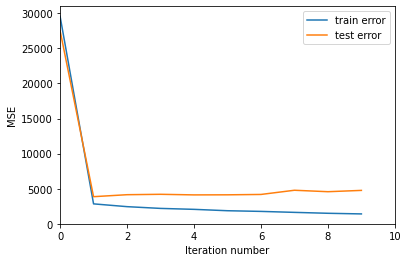

In [146]:
get_error_plot(n_trees, train_errors, test_errors)

Задание 1: Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Такой результат не является удовлетворительным

In [147]:
from tqdm import tqdm_notebook, tnrange
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

n_trees = [5, 10, 20, 40, 80, 120]
tree_depth = [1,2,3, 5, 10]
# tree_depth = [1,2,3]

num_of_trees = len(n_trees)
num_of_depths = len(tree_depth)

err = np.zeros((num_of_trees,num_of_depths))
coefs = [1] * num_of_trees
eta = 0.1

for i in tnrange(num_of_trees):
    for j in tnrange(num_of_depths, leave=False):
        coefs = [1] * n_trees[i]
        trees, train_errors, test_errors = gb_fit(n_trees[i], tree_depth[j], X_train, X_test, y_train, y_test, coefs, eta)
        err[i][j] = test_errors[-1]




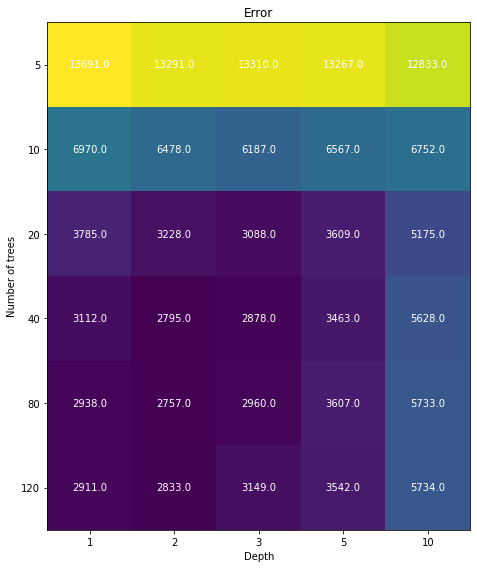

In [148]:
fig, ax = plt.subplots(figsize=(16,8))
im = ax.imshow(err)

# We want to show all ticks...
ax.set_xticks(np.arange(num_of_depths))
ax.set_yticks(np.arange(num_of_trees))
# ... and label them with the respective list entries
ax.set_xticklabels(tree_depth)
ax.set_yticklabels(n_trees)
err_rounded = np.round(err, decimals=0)
# Loop over data dimensions and create text annotations.
for i in range(num_of_trees):
    for j in range(num_of_depths):
        text = ax.text(j, i, err_rounded[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Error")
ax.set_xlabel('Depth')
ax.set_ylabel('Number of trees')
fig.tight_layout()
plt.show()

Наименьшая ошибка на тестовой выборке при значениях глубины дерева 2 и количества деревьев 80, при увеличении или уменьшении этих параметров ошибка на тесте ухудшается. Следоватеьно для каждой модели их нужно подбирать кросс валидацией. Видно что большая глубина сильно переобучает наш алгоритм.